In [165]:
from scipy.integrate import solve_ivp
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np

# Plotting parameters
plt.rc("text", usetex=True)
plt.rc("font", family="serif", size=14)
plt.rc("lines", linewidth=2)
plt.rc("axes", grid=False)


In [182]:
# Initial Pressures and Temperatures

T = 20 + 273.15  # K

# Dimensions
A_s = 23.14e-3 * 124e-3# m^2 
A_p = 1.134 * 10**-3  # piston area (m^2)
A_v = 1.4 * 10**-5  # valve orifice area (m^2)
C_d = 0.4  # Discharge coefficient
L_low_bore = 0.35 # m
L_upp_bore = 0.1 # m 
L_p = 0.0313  # Height of piston (m)
h_fill = 0.2

# Scientific Constants
k = 1.3  # Specific heat ratio
R = 296.8  # J/kg.K
c_p = 1040  # J/kg.K
g = 9.81  # m/s^2

# Masses
rho_w = 1000  # Density of water (kg/m^3)
m_w = 0.25 # kg -- measured
m_piston = 0.0903  # Mass of pusher piston (kg)


In [175]:
# Initial Conditions

x_p0 = 0  # Initial position pusher (m)
x_p_dot0 = 0
x_s0 = x_p0 + L_low_bore +  h_fill # Test section water height (m)
x_s_dot0 = 0

p_r0 = 250 * 6895  # reservoir initial pressure in Pa
p_p0 = 101325  # initial pressure under pusher piston in Pa
p_s = 101325 # Pa

# Initial Volumes
V_r = 517.9 * 10**-6  # Reservoir volume (m^3)
V_p0 = L_low_bore*A_p  # Volume under pusher piston (m^3)

m_r0 = p_r0 * V_r / (R * T)  # kg
m_p0 = p_p0 * V_p0 / (R * T)  # kg


y0 = [m_r0, p_r0, m_p0, p_p0, x_p0, x_p_dot0, x_s0, x_s_dot0]

In [176]:
def ode(t,y):
    m_r = y[0]
    p_r = y[1]
    m_p = y[2]
    p_p = y[3]
    x_p = y[4]
    x_p_dot = y[5]
    x_s = y[6]
    x_s_dot = y[7]
    
    V_p = A_p * x_p + V_p0 # Volume under pusher piston (m^3) 

    if (p_p / p_r) < 0.5283:
        # Choked flow condition
        m_r_dot = C_d*(- A_v * p_r * sqrt(k / (R * T)) * (2 / (k + 1)) ** ((k + 1) / (2 * (k - 1))))
    else:
        # Unchoked flow condition
        m_r_dot = C_d * (-A_v * p_r / sqrt(R * T) * (p_p / p_r) ** (1 / k) * \
                sqrt((2 * k / (k - 1)) * (1 - (p_p / p_r) ** ((k - 1) / k))))


    p_r_dot = m_r_dot*k*R*T/V_r

    m_p_dot = -m_r_dot

    p_p_dot = 1/V_p * ((k+1)*c_p*m_p_dot*T-k*p_p*A_p*x_p_dot)

    x_p_ddot = (- A_s*p_s + A_p*p_p  - (m_w + m_piston)*g)/m_piston

    x_s_dot = A_p/A_s * x_p_dot

    x_s_ddot = (-A_s*p_s + A_p*p_p - m_w*g)/m_w

    if x_p_ddot < 0: #Prevent Piston from going below 0
        x_p_ddot = 0
        x_p_dot = 0
        x_s_dot = 0
        x_s_ddot = 0

    if x_p > L_upp_bore:
        x_p = L_upp_bore
        x_p_ddot = 0
        x_p_dot = 0
        x_s_dot = 0
        x_s_ddot = 0
    


    y_dot = [m_r_dot, p_r_dot, m_p_dot, p_p_dot, x_p_dot, x_p_ddot, x_s_dot, x_s_ddot]
    
    return y_dot

In [177]:
solution = solve_ivp(ode, t_span = (0,0.05), y0 = y0, method='RK23')

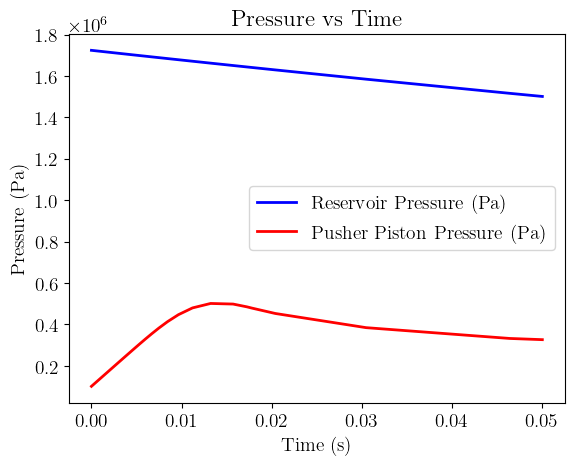

In [178]:
# Extract the solution
t = solution.t
y = solution.y

# Plot pressures
plt.figure()
plt.plot(t, y[1], label="Reservoir Pressure (Pa)", color = 'blue')
plt.plot(t, y[3], label="Pusher Piston Pressure (Pa)", color = 'red')
plt.xlabel('Time (s)')
plt.ylabel('Pressure (Pa)')
plt.legend()
plt.title('Pressure vs Time')
plt.show()

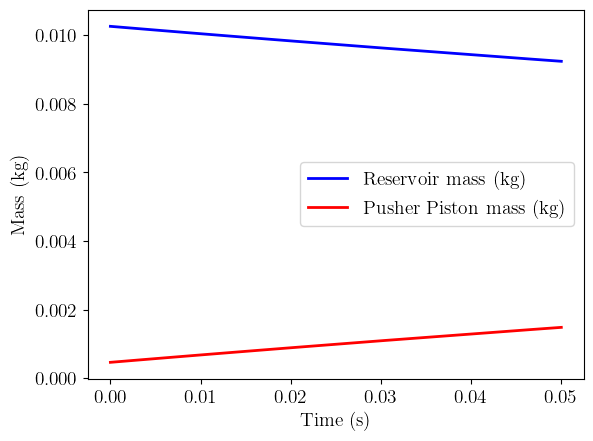

In [179]:
# Plot mass flow
plt.figure()
plt.plot(t, y[0], label="Reservoir mass (kg)", color = 'blue')
plt.plot(t, y[2], label="Pusher Piston mass (kg)", color = 'red')
plt.xlabel('Time (s)')
plt.ylabel('Mass (kg)')
plt.legend()
plt.show()

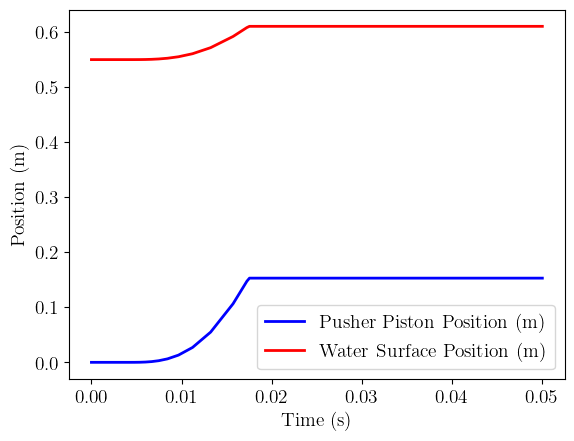

In [180]:
# Plot positions
plt.figure()
plt.plot(t, y[4], label="Pusher Piston Position (m)",  color = 'blue')
plt.plot(t, y[6], label="Water Surface Position (m)", color = 'red')
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.legend()
plt.show()

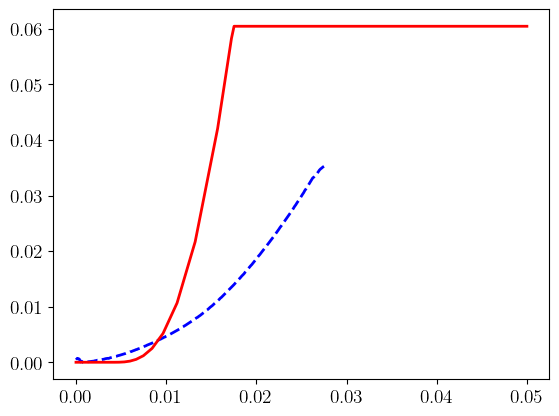

In [184]:


edges = np.load(r"./free_surface_data.npy")  # Load the saved array
y_values = edges[1, :, :] * 0.2  # Extract y-values
avg_y = np.mean(y_values, axis=0)/1000  # Compute average y-value per frame
time = np.arange(avg_y.shape[0]) / 8000  # Generate frame numbers
plt.plot(time, avg_y-np.min(avg_y), marker="none", linestyle="--", color="b", label="Avg Y")
plt.plot(t, y[6]-np.min(y[6]), label="Water Surface Position (m)", color = 'red')
plt.show()